# 4. Running Tensor-cell2cell to perform a tensor factorization

After generating a 4D-Communication Tensor, we can run Tensor-cell2cell to perform a tensor factorization and obtain the context-driven patterns of cell-cell communication (factors).

This tutorial will show you how to load a previously exported 4D-Communication Tensor and run Tensor-cell2cell on this tensor.

## Initial Setup

**Before running this notebook** 

GPUs can substantially speed-up this analysis. If you are planning to use a NVIDIA GPU, make sure to have a proper NVIDIA GPU driver (https://www.nvidia.com/Download/index.aspx) as well as the CUDA toolkit (https://developer.nvidia.com/cuda-toolkit) installed.

Then, make sure to create an environment with PyTorch version >= v1.8 following these instructions to enable CUDA.

https://pytorch.org/get-started/locally/

### Enabling GPU use

If you are using a NVIDIA GPU, after installing PyTorch with CUDA enabled, specify `use_gpu = True`. Otherwise, `use_gpu = False`.

In [1]:
use_gpu = True

When using a GPU, first import tensorly and set the backend to be `'pytorch'`. 

In [2]:
if use_gpu:
    import tensorly as tl
    tl.set_backend('pytorch')

### Import Libraries

In [3]:
import os

import pandas as pd
import numpy as np

import cell2cell as c2c

%matplotlib inline

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Directories

In [5]:
output_folder = '../../data/tc2c-outputs/'

## Load Tensor

Now, we can load our 4D-Communication Tensor that was previously exported with pickle.

In [6]:
tensor = c2c.io.read_data.load_tensor(os.path.join(output_folder, 'BALF-Tensor.pkl'))

Load metadata

In [7]:
meta_tensor = c2c.io.load_variable_with_pickle(os.path.join(output_folder, 'BALF-Tensor-Metadata.pkl'))

## Perform Tensor Factorization

Tensor-cell2cell can be run with a simple pipeline command that executes all important steps to perform the tensor factorization.


**Key parameters are:**

- `copy_tensor` indicates whether modifying the original tensor passed as input to report the results or return a new version including the results.


- `rank` is the number of factors or latent patterns we want to obtain from the analysis. You can either indicate a specific number or leave it as `None` to obtain a suggested number through an elbow analysis.


- `tf_optimization` indicates whether running the analysis in the `'regular'` or the `'robust'` way. The regular way means that the tensor decomposition is run 10 times per rank evaluated in the elbow analysis, and 1 time in the final decomposition. Additionally, the optimization algorithm has less number of iterations in the regular than the robust case (100 vs 500) and less precision (tolerance of 1e-7 vs 1e-8). The robust case runs the tensor decomposition 20 times per rank evaluated in the elbow analysis, and 100 times in the final decomposition. Here we could use the ```tf_optimization='regular'```, which is faster but generates less robust results. We recommend using ```tf_optimization='robust```, which takes longer to run (more iteractions and more precise too). It is important to notice that multiple runs of a tensor decomposition differ in the initialization values (regardless of using `tf_init='random'` or `tf_init='svd'`).


- `random_state` is the seed for randomization. It controls the randomization used when initializing the optimization algorithm that performs the tensor decomposition. It is useful for reproducing the same result every time that the analysis is run. If `None`, a different randomization will be used each time.


- `device` indicates whether we are using the `'cpu'` or a GPU with `'cuda'` cores. See the beginning of this notebook to enable using a GPU.


- `'elbow_metric'` is the metric to perform the elbow analysis to obtain a suggested number of factors. Options are `'error'` and `'similarity'`, indicating respectively the error of tensor reconstruction, and the similarity of tensor factorization across multiple runs for a given rank. The similarity metric may result in non-smooth curves given the highly variability especially at higher ranks. If so, we recommend using the parameter `smooth_elbow=True`.


- `uppper_rank` is the max number of ranks to try in the elbow analysis.


- `tf_init` is the initialization of the tensor decomposition algorithm. If your tensor contains a mask (`tensor.mask`), it will automatically use `tf_init='random'`. Options are `'random'` and `'svd'`. The latter helps to obtain results that are more close to a global optima from the optimization method behind the algorithm.


- `tf_svd` is the method to perform the SVD to initialize the tensor factorization. This is only considered whe `tf_init='svd'`. 


- `output_folder` is the full path to the folder where the results will be saved. Make sure that this folder exists before passing it here.

Running Elbow Analysis


100%|███████████████████████████████████████████████████████████████| 25/25 [37:34<00:00, 90.17s/it]


The rank at the elbow is: 10
Running Tensor Factorization


100%|█████████████████████████████████████████████████████████████| 100/100 [06:24<00:00,  3.84s/it]


Best model has a normalized error of: 0.505
Generating Outputs
Loadings of the tensor factorization were successfully saved into ../../data/tc2c-outputs//Loadings.xlsx
CPU times: user 44min 10s, sys: 619 ms, total: 44min 10s
Wall time: 44min 11s


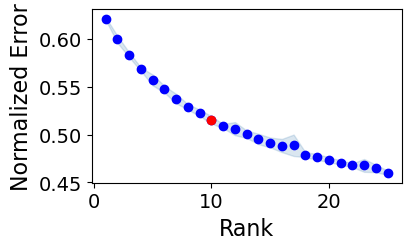

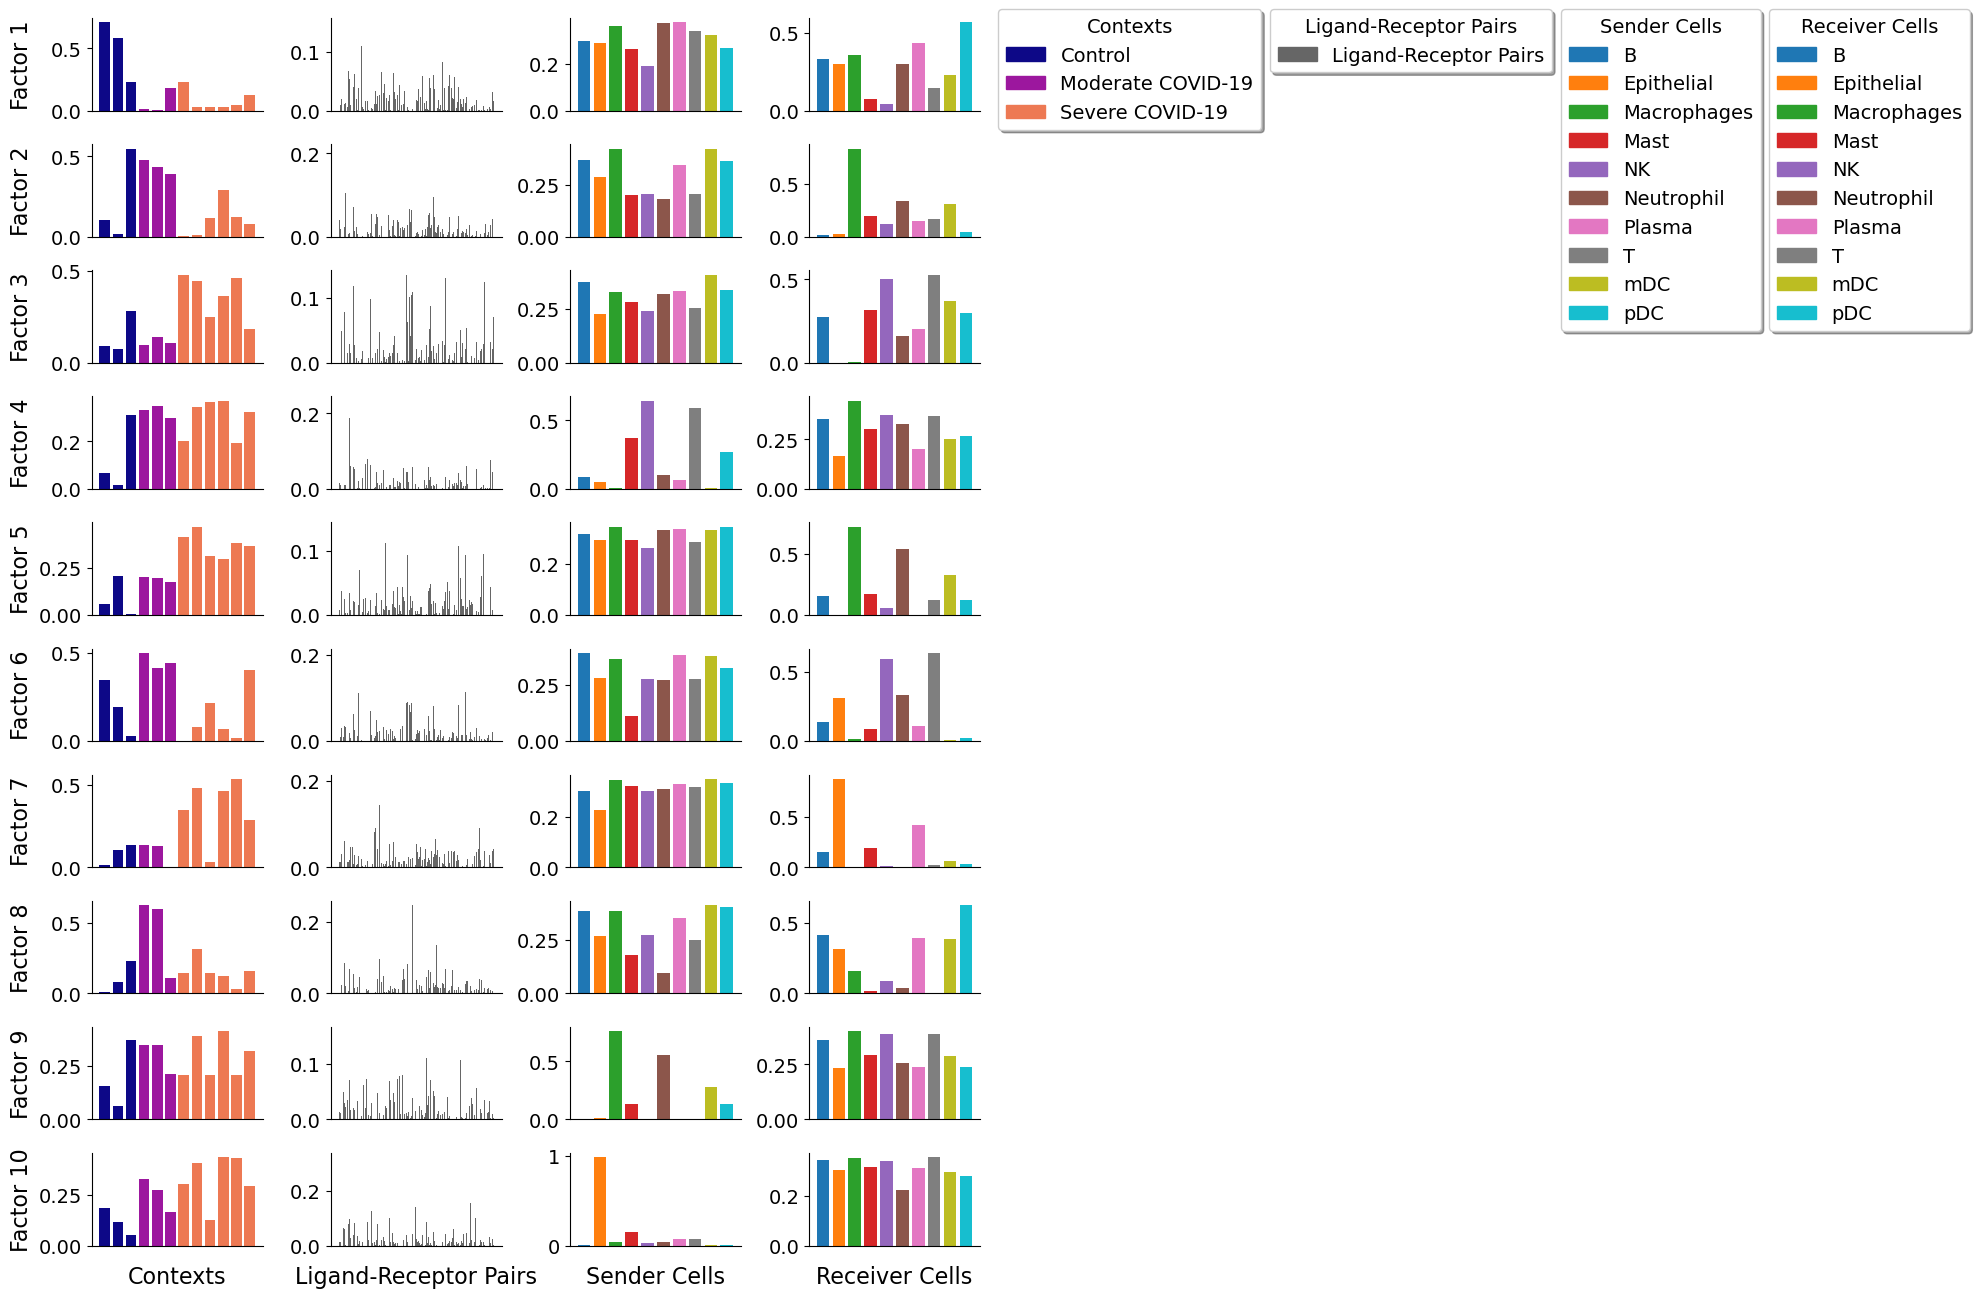

In [8]:
%%time
tensor2 = c2c.analysis.run_tensor_cell2cell_pipeline(tensor,
                                                     meta_tensor,
                                                     copy_tensor=True, # Whether to output a new tensor or modifying the original
                                                     rank=None, # Number of factors to perform the factorization. If None, it is automatically determined by an elbow analysis
                                                     tf_optimization='robust', # To define how robust we want the analysis to be.
                                                     random_state=0, # Random seed for reproducibility
                                                     device='cuda', # Device to use. If using GPU and PyTorch, use 'cuda'. For CPU use 'cpu'
                                                     elbow_metric='error', # Metric to use in the elbow analysis.
                                                     smooth_elbow=False, # Whether smoothing the metric of the elbow analysis.
                                                     upper_rank=25, # Max number of factors to try in the elbow analysis
                                                     tf_init='random', # Initialization method of the tensor factorization
                                                     tf_svd='numpy_svd', # Type of SVD to use if the initialization is 'svd'
                                                     cmaps=None, # Color palettes to use in color each of the dimensions. Must be a list of palettes.
                                                     sample_col='Element', # Columns containing the elements in the tensor metadata
                                                     group_col='Category', # Columns containing the major groups in the tensor metadata
                                                     fig_fontsize=14, # Fontsize of the figures generated
                                                     output_folder=output_folder, # Whether to save the figures in files. If so, a folder pathname must be passed
                                                     output_fig=True, # Whether to output the figures. If False, figures won't be saved a files if a folder was passed in output_folder.
                                                     fig_format='pdf', # File format of the figures.
                                                    )

## Factorization Results

After running the decomposition, the results are stored in the `factors` attribute (`tensor2.factors`). This attribute is a dictionary containing the loadings for each of the elements in every tensor dimension. Keys are the names of the different dimension.

In [9]:
tensor2.factors.keys()

odict_keys(['Contexts', 'Ligand-Receptor Pairs', 'Sender Cells', 'Receiver Cells'])

We can inspect the loadings of the samples, for example, located under the key `'Contexts'`.

In [10]:
tensor2.factors['Contexts']

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9,Factor 10
HC1,0.708322,0.104737,0.090899,0.068597,0.056585,0.348333,0.011751,0.010677,0.155580,0.184025
HC2,0.583005,0.016801,0.075149,0.016643,0.206293,0.193095,0.105770,0.078638,0.062675,0.116539
HC3,0.229497,0.549203,0.279390,0.310239,0.006598,0.030883,0.135658,0.231957,0.370718,0.052132
M1,0.008884,0.478022,0.098610,0.334124,0.198149,0.500957,0.135596,0.623529,0.346221,0.329193
M2,0.004919,0.431901,0.140348,0.349510,0.194244,0.413197,0.127818,0.599028,0.348139,0.272664
M3,0.181776,0.388515,0.104921,0.298354,0.171414,0.446122,0.001239,0.110907,0.209971,0.164483
S1,0.225939,0.002075,0.478845,0.200954,0.412503,0.002279,0.345798,0.145365,0.205606,0.303407
S2,0.032451,0.011212,0.443589,0.346494,0.464173,0.080372,0.481296,0.310248,0.390459,0.406946
S3,0.026430,0.118665,0.250201,0.367463,0.311271,0.215456,0.033697,0.141541,0.206051,0.125222
S4,0.028198,0.292207,0.364289,0.371689,0.297431,0.067789,0.463423,0.125962,0.410685,0.436202


If we are interested in the top elements of a given dimension, here for example `'Ligand-Receptor Pairs'`, we can easily obtain them:

In [11]:
# Top 10 LR pairs in the Factor 10
tensor2.get_top_factor_elements(order_name='Ligand-Receptor Pairs', 
                                factor_name='Factor 10', 
                                top_number=10)

COL9A3^CD44                  0.323394
SLPI^PLSCR1                  0.154680
HP^TLR4                      0.142395
MDK^TSPAN1                   0.132488
VCAN^TLR1                    0.132404
CD59^CD2                     0.125173
MDK^NCL                      0.118178
TGFB1^ACVR1_TGFBR1_TGFBR2    0.112601
CADM1^CRTAM                  0.111984
VCAN^TLR2                    0.109834
Name: Factor 10, dtype: float32

## Supplementary Information about the Tensor Decomposition

To show the steps here, we will make a copy of the original tensor object

In [12]:
interaction_tensor = tensor.copy()

### The one-line command used to run Tensor-cell2cell (`c2c.analysis.run_tensor_cell2cell_pipeline()`) performs three main things under-the-hood:

**1- Allocates the tensor in the device to use**

In [13]:
device = 'cuda'
interaction_tensor.to_device(device)

**2- If no rank was specified, it performs the elbow analysis**

Main parameters are:

- `uppper_rank` is the max number of ranks to try in the elbow analysis.


- `runs` is the number of tensor decompositions (using different randomizations for initializing the algorithm) to perform per rank. If more than 1 is passed, the plot will show the mean of the metric and its standard deviation for each evaluated rank.


- `init` is the initialization of the tensor decomposition algorithm. If your tensor contains a mask (`tensor.mask`), it will automatically use `init='random'`. Options are `'random'` and `'svd'`. The latter helps to obtain results that are more close to a global optima from the optimization method behind the algorithm.


- `svd` is the method to perform the SVD to initialize the tensor factorization. This is only considered whe `init='svd'`. 


- `automatic_elbow` indicates whether suggesting a rank number to perform the decomposition. If `False`, this analysis will only report the curve, then the user can make a decision of what rank number to use in the final decomposition.


- `'metric'` is the metric to perform the elbow analysis to obtain a suggested number of factors. Options are `'error'` and `'similarity'`, indicating respectively the error of tensor reconstruction, and the similarity of tensor factorization across multiple runs for a given rank. The similarity metric may result in non-smooth curves given the highly variability especially at higher ranks. If so, we recommend using the parameter `smooth_elbow=True`.


- `random_state` is the seed for randomization. It controls the randomization used when initializing the optimization algorithm that performs the tensor decomposition. It is useful for reproducing the same result every time that the analysis is run. If `None`, a different randomization will be used each time.


- `filename` is the full path name of the file wherein the figure is saved (even indicating the extension). For example, '/home/user/Elbow.pdf'. If `None` the figure will not be saved.

Here we can also specify the `tol`and the `n_iter_max`, which are the parameters associated with the `tf_optimization` parameter in the `c2c.analysis.run_tensor_cell2cell_pipeline()` function.

For 'regular' we use `tol=1e-7` and `n_iter_max=100`, while for 'robust' these parameters are `tol=1e-8` and `n_iter_max=500`

100%|███████████████████████████████████████████████████████████████| 25/25 [03:59<00:00,  9.58s/it]

The rank at the elbow is: 11


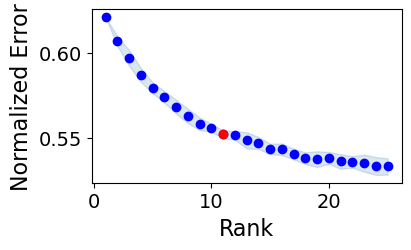

In [14]:
fig1, error = interaction_tensor.elbow_rank_selection(upper_rank=25,
                                                      runs=10,
                                                      init='random',
                                                      svd='numpy_svd',
                                                      automatic_elbow=True,
                                                      metric='error',
                                                      random_state=0,
                                                      fontsize=14,
                                                      filename=None,
                                                      tol=1e-7, n_iter_max=100,
                                                      )

Here, the error measures how different is the original tensor from the sum of R rank-1 tensors used to approximate it. The idea is to find a good trade-off between a small number of factors and a small error.

![factors](https://earmingol.github.io/cell2cell/tutorials/ASD/figures/tensor-approx.png)

**3- Tensor Factorization/Decomposition**

After knowing that number of factors (rank) to use, we can perform the tensor decompositon.

Main parameters are:

- `rank` is the number of factors or latent patterns to obtain from the tensor decomposition.


- `runs` is the number of tensor decompositions (using different randomizations for initializing the algorithm) to perform. If more. than 1 is assigned, the result that minimizes the tensor-reconstruction error will be output.


- `init` is the initialization of the tensor decomposition algorithm. If your tensor contains a mask (`tensor.mask`), it will automatically use `init='random'`. Options are `'random'` and `'svd'`. The latter helps to obtain results that are more close to a global optima from the optimization method behind the algorithm.


- `svd` is the method to perform the SVD to initialize the tensor factorization. This is only considered whe `init='svd'`. 


- `random_state` is the seed for randomization. It controls the randomization used when initializing the optimization algorithm that performs the tensor decomposition. It is useful for reproducing the same result every time that the analysis is run. If `None`, a different randomization will be used each time.

In [15]:
# From the elbow analysis, the suggested rank is found in
interaction_tensor.rank

11

Here we can also specify the `tol`and the `n_iter_max`, which are the parameters associated with the `tf_optimization` parameter in the `c2c.analysis.run_tensor_cell2cell_pipeline()` function.

For 'regular' we use `tol=1e-7` and `n_iter_max=100`, while for 'robust' these parameters are `tol=1e-8` and `n_iter_max=500`

In [16]:
interaction_tensor.compute_tensor_factorization(rank=interaction_tensor.rank,
                                                init='random',
                                                svd='numpy_svd',
                                                random_state=0,
                                                runs=100,
                                                normalize_loadings=True,
                                                tol=1e-8, n_iter_max=500,
                                                )

100%|█████████████████████████████████████████████████████████████| 100/100 [06:50<00:00,  4.11s/it]

Best model has a normalized error of: 0.503


The tensor decomposition performed here is a non-negative canonical polyadic decomposition (CPD) (same performed in the elbow analysis). Briefly, tensor decomposition identifies a low-rank tensor (here, a rank of 11) that approximated the full tensor. This low-rank tensor can be represented as the sum of a set of rank-1 tensors (10 of them in this case). Each rank-1 tensor represents a factor in the decomposition and can be further represented as the outer product of n vectors, where n represents the number of tensor dimensions. Each vector represents one of the n tensor dimensions for that factor and its values, corresponding to individual elements in each dimension, represent the factor loadings. In our case, each factor will contain loadings for the context, LR pair, sender-cell, and receiver-cell dimensions. Those elements within each factor that contain high loadings contribute to the factor-specific communication pattern.

![TF](https://earmingol.github.io/cell2cell/tutorials/ASD/figures/tensor-factorization.png)

We can plot the results with:

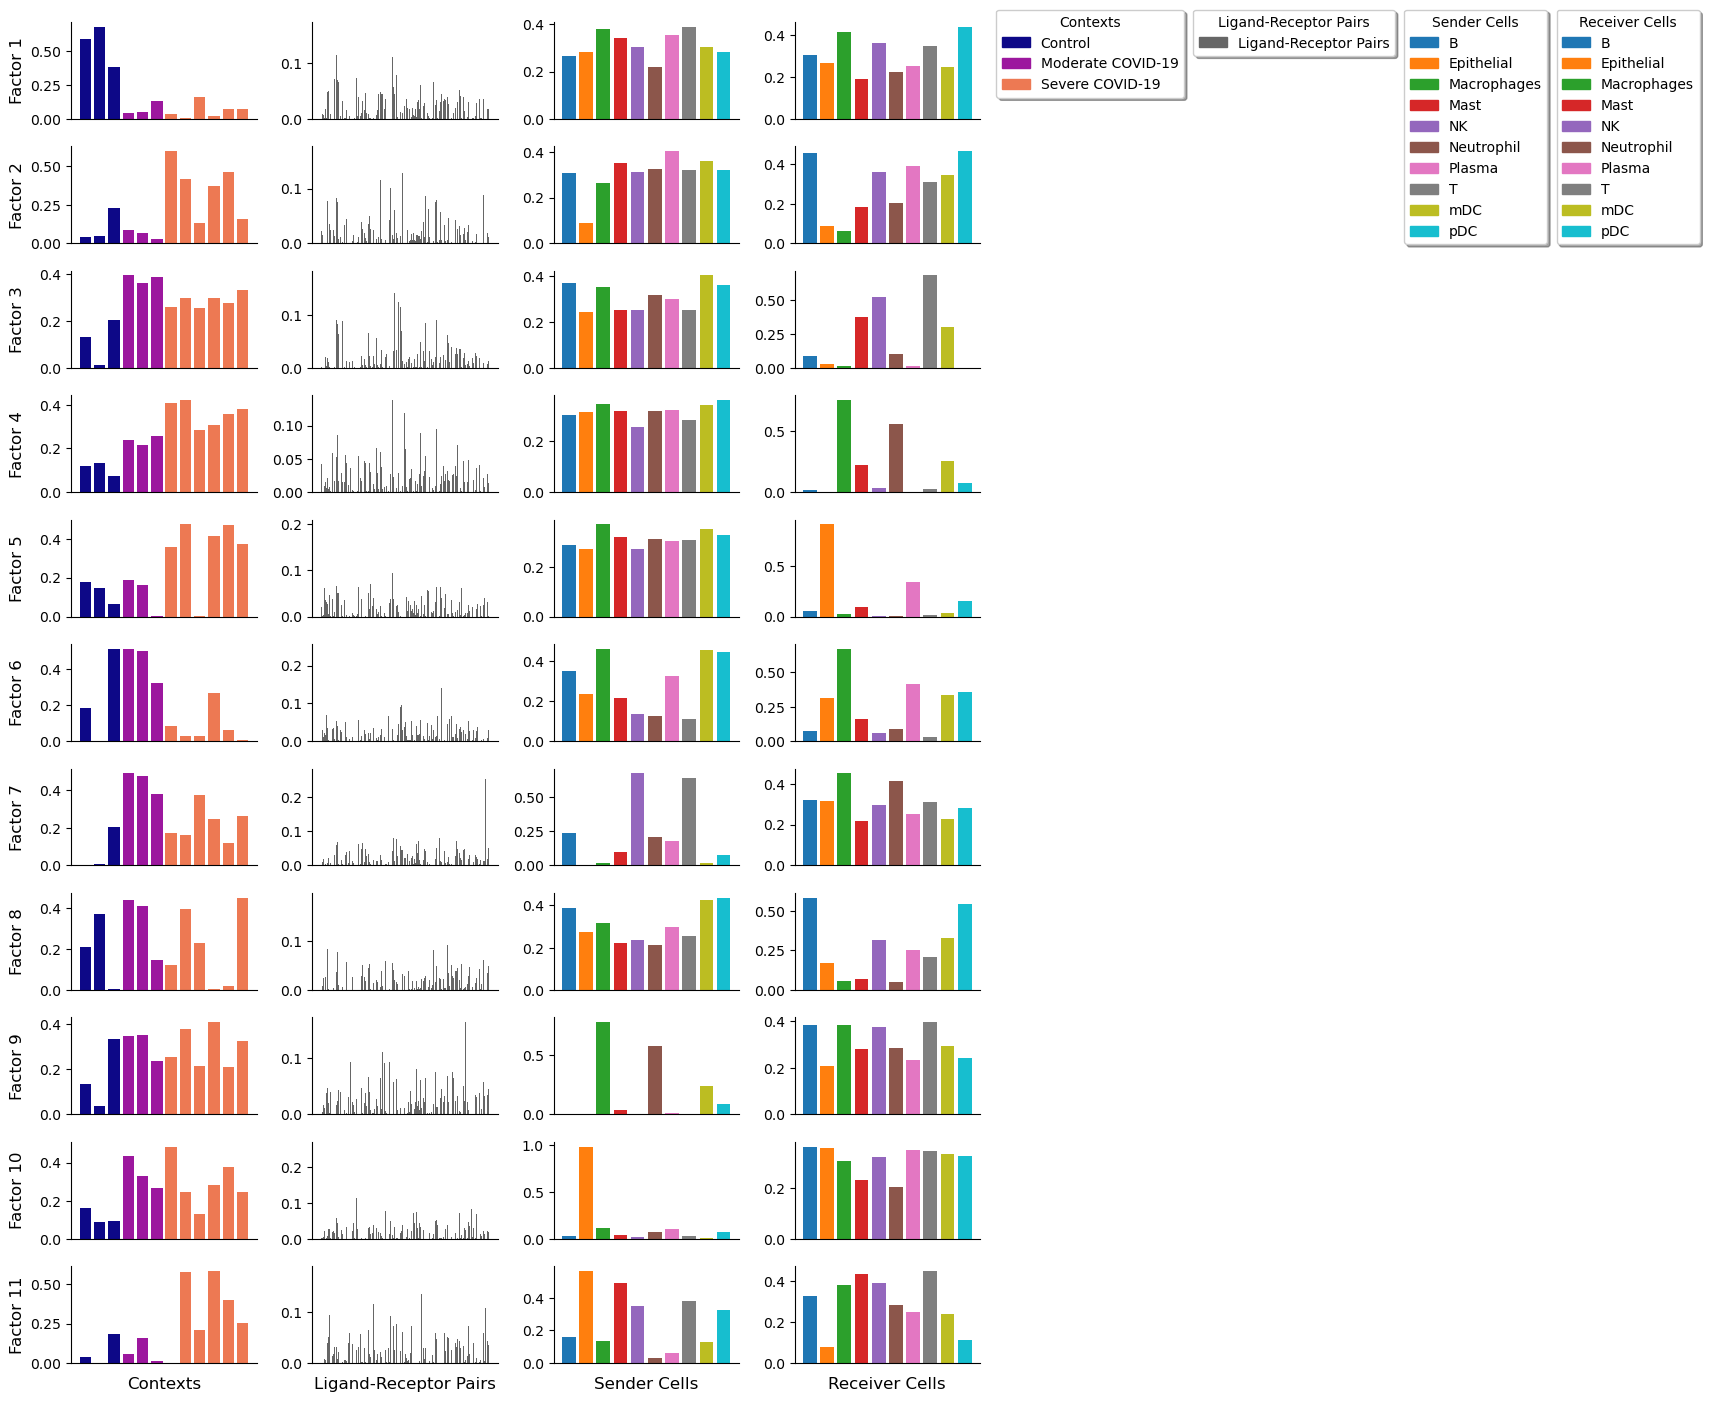

In [17]:
factors, axes = c2c.plotting.tensor_factors_plot(interaction_tensor=interaction_tensor,
                                                 metadata = meta_tensor, # This is the metadata for each dimension
                                                 sample_col='Element',
                                                 group_col='Category',
                                                 meta_cmaps = ['plasma', 'Dark2_r', 'tab20', 'tab20'],
                                                 fontsize=10, # Font size of the figures generated
                                                 filename=None # Path to save the figure. E.g. '/home/user/TF.pdf'
                                                 )

### Subset of a Tensor


From this analysis we may also be interested in a subset of the original tensor to inspect the cell-cell communication of a subset of samples, LR pairs, sender cells, or receiver cells.

We can subset the original tensor without having to build it from the beginning. For example, we are interested in the CCC of NKs and T cells as the senders, and B cells, Macrophages, mDC and pDC cells as receivers. We can do so by creating a dictionary specifying the elements of the dimensions that we want to subset. Here, the dimensions corresponds to:
- `0` for the Contexts
- `1` for the Ligand-Receptor Pairs
- `2` for the Sender Cells
- `3` for the Receiver Cells

If we do not include a dimension in the following dictionary, that dimension will not be subset.

In [18]:
subset_dict = {2: ['NK', 'T'], # Sender Cells
               3: ['B', 'Macrophages', 'mDC', 'pDC'] # Receiver Cells
              }

Some key parameters here are:

- `original_order` indicates whether keeping the element order as in the original tensor or as in the subset list.

- `remove_duplicates` indicates whether removing duplicate elements in the subset lists. Duplicates can be introduced especially when passing these lists manually.

- `keep` indicates what duplicated element to keep. Options are:
    - 'first' : Drop duplicates except for the first occurrence.
    - 'last' : Drop duplicates except for the last occurrence.
    - False : Drop all duplicates.

In [19]:
subset_tensor = c2c.tensor.subset_tensor(interaction_tensor=tensor,
                                         subset_dict=subset_dict,
                                         original_order=True 
                                        )

If we compare the size of the original tensor with the subset one, we can see that we only modified the senders and receiver cells.

In [20]:
print(tensor.tensor.shape, subset_tensor.tensor.shape)

torch.Size([12, 1054, 10, 10]) torch.Size([12, 1054, 2, 4])


Now with this subset tensor, we have to subset the metadata as well. With the following function we can pass the subset tensor as reference to adapt the metadata correspondingly.

In [21]:
subset_meta = c2c.tensor.subset_metadata(tensor_metadata=meta_tensor,
                                         interaction_tensor=subset_tensor
                                        )

**With this subset tensor and metadata (`subset_tensor` and `subset_meta`), we can run the Tensor-cell2cell analysis as indicated earlier in this tutorial**